# **Install Dependencies**

In [1]:
!pip install ultralytics mlflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.4/808.4 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/

# **Import Modules**

In [2]:
import torch
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import kagglehub
import os
import random
import numpy as np
import albumentations as A
import cv2
import shutil
import mlflow
import mlflow.pytorch

from ultralytics import YOLO
from pathlib import Path
from PIL import Image
from accelerate import Accelerator
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

from google.colab import drive
drive.mount("/content/drive")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


# **Download Dataset**

In [3]:
path = kagglehub.dataset_download("riooorante/e-ktp-indonesia-fake-dataset")

print("Path to dataset files:", path)

100%|██████████| 124M/124M [00:06<00:00, 18.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/riooorante/e-ktp-indonesia-fake-dataset/versions/1


In [4]:
BASE_DATA_DIR = os.path.join(path, "Generated E-ktp")
IMAGE_DATA_DIR = os.path.join(BASE_DATA_DIR, "images")
LABEL_DATA_DIR = os.path.join(BASE_DATA_DIR, "labels")


WORKING_DIR = "/kaggle/working/Generated E-ktp"
LABEL_GDINO_DIR = os.path.join(WORKING_DIR, "labels_gdino")
OUTPUT_IMAGE_DIR = os.path.join(WORKING_DIR, "augmented", "images")
OUTPUT_LABEL_DIR = os.path.join(WORKING_DIR, "augmented", "labels")
CLASSES_PATH = os.path.join(WORKING_DIR, "classes_gdino.txt")

os.makedirs(LABEL_GDINO_DIR, exist_ok=True)
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# **Annotate Image with Grounding Dino**

In [5]:
TEXT_LABELS = [["indonesian id card", "a human photo inside the id card"]]
CLASS_NAMES = ["id card", "photo"]
LABEL_MAP = {
    "indonesian id card" : "id card",
    "a human photo inside the id card": "photo",
}

COLORS = ["red", "blue"]

THRESHOLD = 0.4
TEXT_THRESHOLD = 0.3

In [6]:
# --- LOAD MODEL ---
model_id  = "IDEA-Research/grounding-dino-tiny"
device    = Accelerator().device

print(f"Device: {device}")
print("Loading model...")

processor = AutoProcessor.from_pretrained(model_id)
model     = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

Device: cuda
Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

The image processor of type `GroundingDinoImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/990 [00:00<?, ?it/s]

In [7]:
def to_yolo(box, img_w, img_h):
    x1, y1, x2, y2 = box
    cx = (x1 + x2) / 2 / img_w
    cy = (y1 + y2) / 2 / img_h
    w  = (x2 - x1) / img_w
    h  = (y2 - y1) / img_h
    return cx, cy, w, h

def label_to_id(label: str) -> int:
    label = label.strip().lower()
    for prompt, short_name in LABEL_MAP.items():
        if prompt in label or label in prompt:
            return CLASS_NAMES.index(short_name)
    return -1

In [8]:
image_files = sorted([
    f for f in os.listdir(IMAGE_DATA_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

In [9]:
total_detected = 0
total_skipped  = 0

for idx, filename in enumerate(image_files):
    img_path   = os.path.join(IMAGE_DATA_DIR, filename)
    label_name = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(LABEL_GDINO_DIR, label_name)

    image  = Image.open(img_path).convert("RGB")
    img_w, img_h = image.size

    inputs = processor(
        images=image,
        text=TEXT_LABELS,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        target_sizes=[(img_h, img_w)]
    )

    result     = results[0]
    yolo_lines = []

    for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
        class_id = label_to_id(label)
        if class_id == -1:
            continue

        cx, cy, w, h = to_yolo(box.tolist(), img_w, img_h)
        yolo_lines.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

    if yolo_lines:
        with open(label_path, "w") as f:
            f.write("\n".join(yolo_lines))
        total_detected += 1
    else:
        # Simpan file kosong supaya YOLO tahu gambar ini tidak ada objek
        open(label_path, "w").close()
        total_skipped += 1
        print(f"  Peringatan: tidak ada deteksi di {filename}")

    if (idx + 1) % 10 == 0:
        print(f"  {idx + 1}/{len(image_files)} gambar diproses")

with open(CLASSES_PATH, "w") as f:
    for name in CLASS_NAMES:
        f.write(name + "\n")

/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:91: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


  10/100 gambar diproses
  20/100 gambar diproses
  30/100 gambar diproses
  40/100 gambar diproses
  50/100 gambar diproses
  60/100 gambar diproses
  70/100 gambar diproses
  80/100 gambar diproses
  90/100 gambar diproses
  100/100 gambar diproses


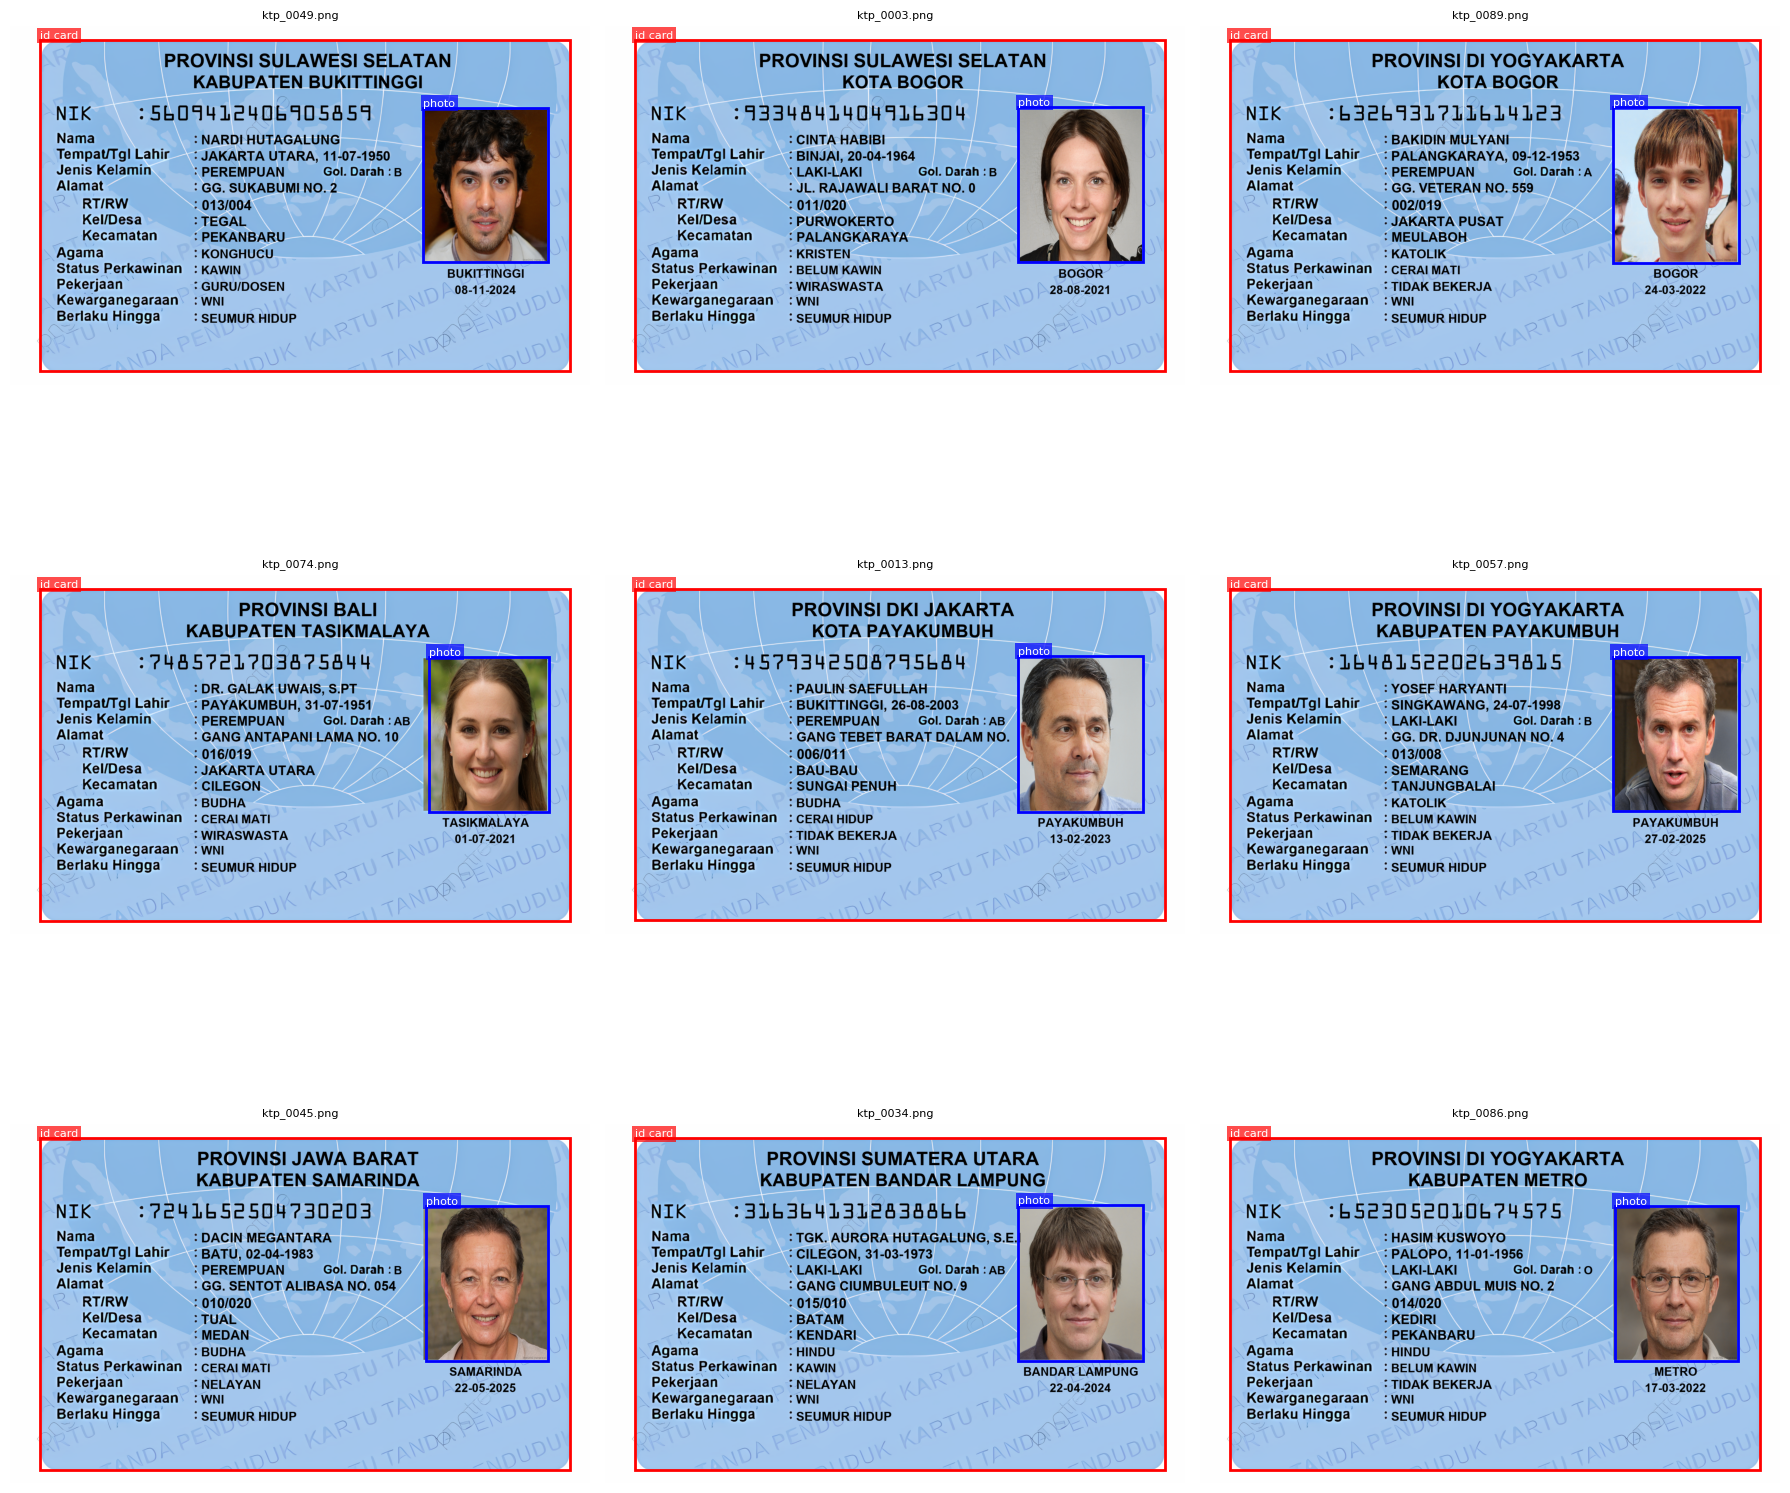

In [10]:
def visualize_sample(n_sample=9):
    files = [f for f in os.listdir(IMAGE_DATA_DIR) if f.lower().endswith(".png")]
    samples = random.sample(files, min(n_sample, len(files)))

    cols = 3
    rows = (len(samples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
    axes = axes.flatten()

    for i, filename in enumerate(samples):
        img_path   = os.path.join(IMAGE_DATA_DIR, filename)
        label_path = os.path.join(LABEL_GDINO_DIR, os.path.splitext(filename)[0] + ".txt")

        image    = Image.open(img_path).convert("RGB")
        img_w, img_h = image.size
        ax       = axes[i]
        ax.imshow(image)

        if os.path.exists(label_path):
            with open(label_path) as f:
                lines = [l.strip() for l in f.readlines() if l.strip()]

            for line in lines:
                parts    = line.split()
                class_id = int(parts[0])
                cx, cy, w, h = map(float, parts[1:])

                x1 = (cx - w / 2) * img_w
                y1 = (cy - h / 2) * img_h
                bw = w * img_w
                bh = h * img_h

                color = COLORS[class_id % len(COLORS)]
                rect  = patches.Rectangle(
                    (x1, y1), bw, bh,
                    linewidth=2, edgecolor=color, facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(
                    x1, y1 - 5,
                    CLASS_NAMES[class_id],
                    fontsize=8, color="white",
                    bbox=dict(facecolor=color, alpha=0.7, pad=2, edgecolor="none")
                )

        ax.set_title(filename, fontsize=8)
        ax.axis("off")

    # Sembunyikan axes yang tidak terpakai
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("sample_annotations.png", dpi=150, bbox_inches="tight")
    plt.show()

visualize_sample(n_sample=9)

# **Data Augmentation**

In [11]:
AUG_PER_IMAGE = 10

In [12]:
transform = A.Compose([
    # Pencahayaan dan warna
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.4),
    A.Blur(blur_limit=3, p=0.3),
    A.HorizontalFlip(p=0.0),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        value=(200, 200, 200),
        p=0.7
    ),
    A.Perspective(scale=(0.02, 0.05), p=0.4),

    A.RandomShadow(p=0.3),
    A.ImageCompression(quality_lower=70, quality_upper=95, p=0.4),

], bbox_params=A.BboxParams(
    format="yolo",
    label_fields=["class_labels"],
    min_visibility=0.5
))

/tmp/ipython-input-3762746906.py:5: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.4),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3762746906.py:8: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipython-input-3762746906.py:19: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=70, quality_upper=95, p=0.4),


In [13]:
def read_label(label_path):
    boxes, class_ids = [], []
    if not os.path.exists(label_path):
        return boxes, class_ids
    with open(label_path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            class_ids.append(int(float(parts[0])))
            boxes.append([float(x) for x in parts[1:]])
    return boxes, class_ids

def write_label(label_path, boxes, class_ids):
    with open(label_path, "w") as f:
        for class_id, box in zip(class_ids, boxes):
            cx, cy, w, h = box
            f.write(f"{int(class_id)} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

In [14]:
total_saved = 0

for filename in image_files:
    stem = Path(filename).stem
    img_path = os.path.join(IMAGE_DATA_DIR, filename)
    label_path = os.path.join(LABEL_GDINO_DIR, stem + ".txt")

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes, class_ids = read_label(label_path)

    if not boxes:
        continue

    for aug_idx in range(AUG_PER_IMAGE):
        try:
            augmented = transform(
                image=image,
                bboxes=boxes,
                class_labels=class_ids
            )

            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_labels = augmented["class_labels"]

            if not aug_boxes:
                continue

            out_name = f"{stem}_aug{aug_idx+1:02d}"
            out_img = os.path.join(OUTPUT_IMAGE_DIR, out_name + ".jpg")
            out_label = os.path.join(OUTPUT_LABEL_DIR, out_name + ".txt")

            cv2.imwrite(out_img, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            write_label(out_label, aug_boxes, aug_labels)
            total_saved += 1

        except Exception as e:
            print(f"  Error saat augmentasi {filename} aug{aug_idx+1}: {e}")

In [15]:
def draw_boxes(ax, image, boxes, class_ids):
    ax.imshow(image)
    img_h, img_w = image.shape[:2]

    for class_id, box in zip(class_ids, boxes):
        cx, cy, w, h = box
        x1 = (cx - w / 2) * img_w
        y1 = (cy - h / 2) * img_h
        bw = w * img_w
        bh = h * img_h

        color = COLORS[class_id % len(COLORS)]
        rect  = patches.Rectangle(
            (x1, y1), bw, bh,
            linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 5,
            CLASS_NAMES[class_id],
            fontsize=7, color="white",
            bbox=dict(facecolor=color, alpha=0.8, pad=2, edgecolor="none")
        )
    ax.axis("off")

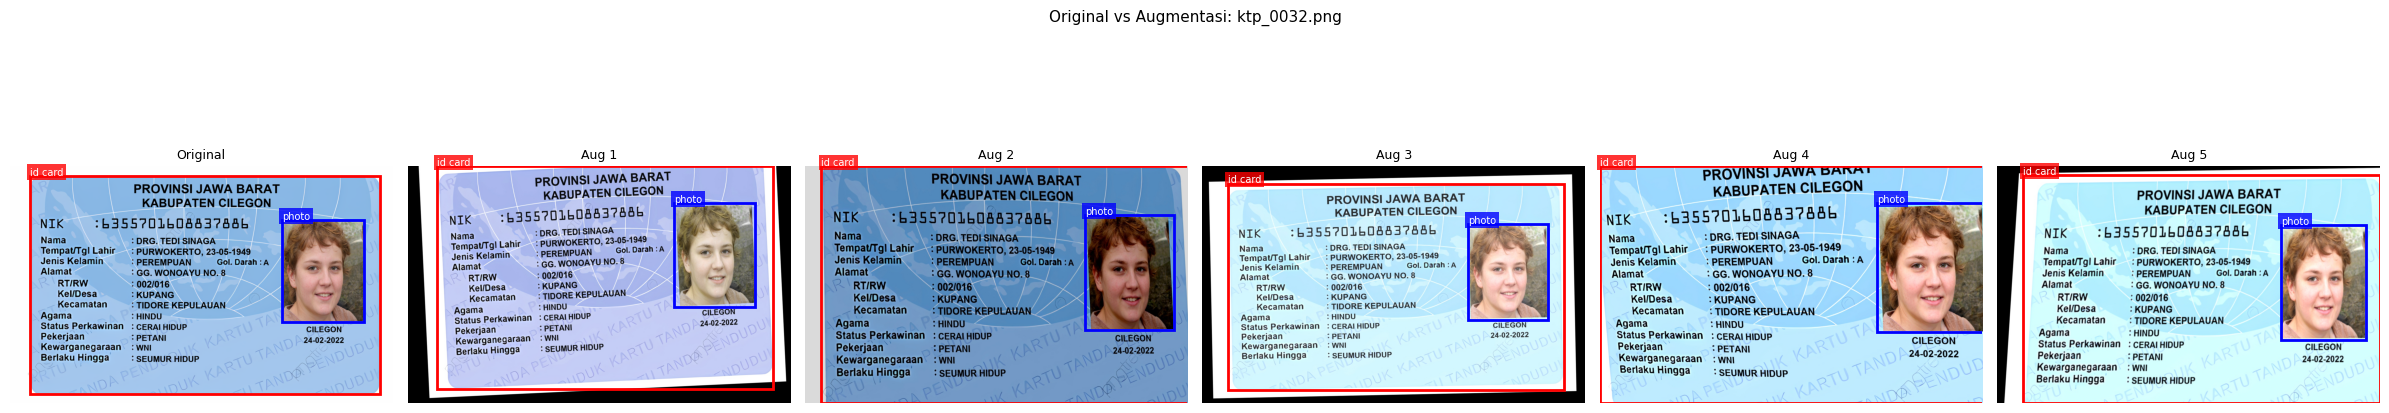

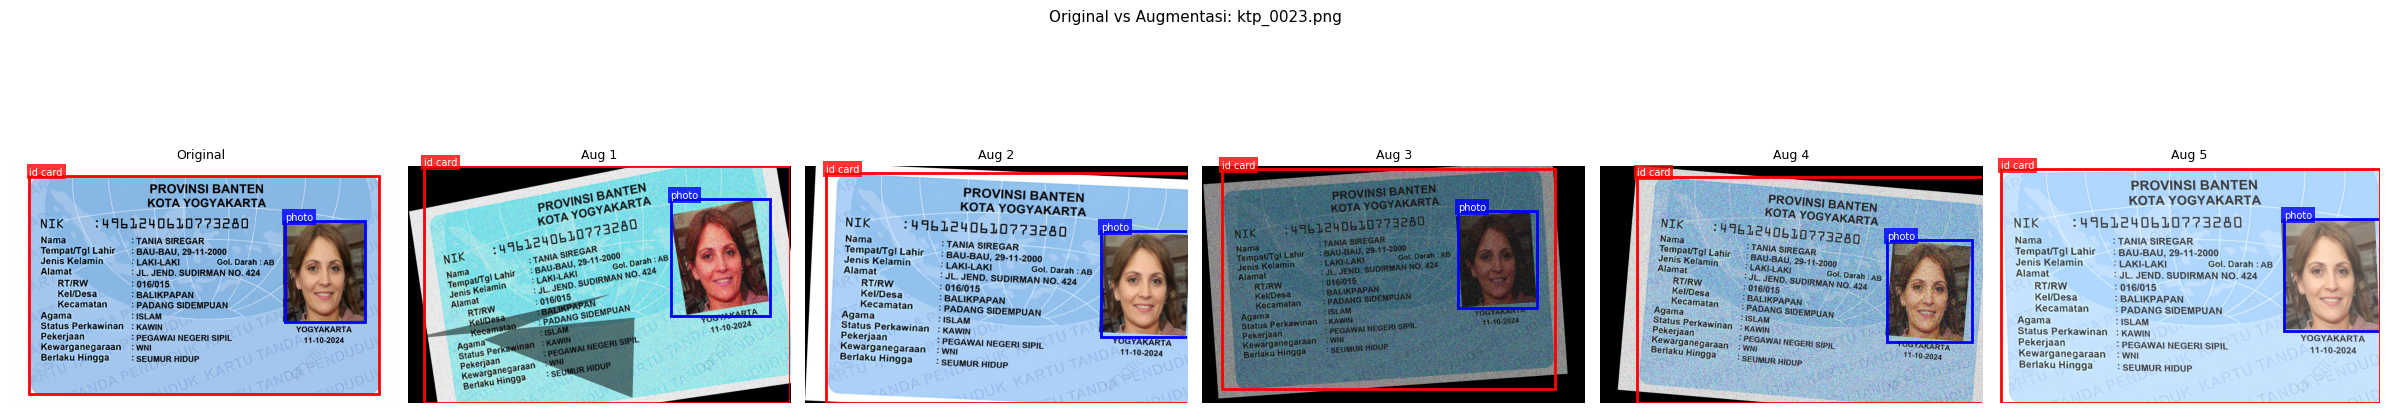

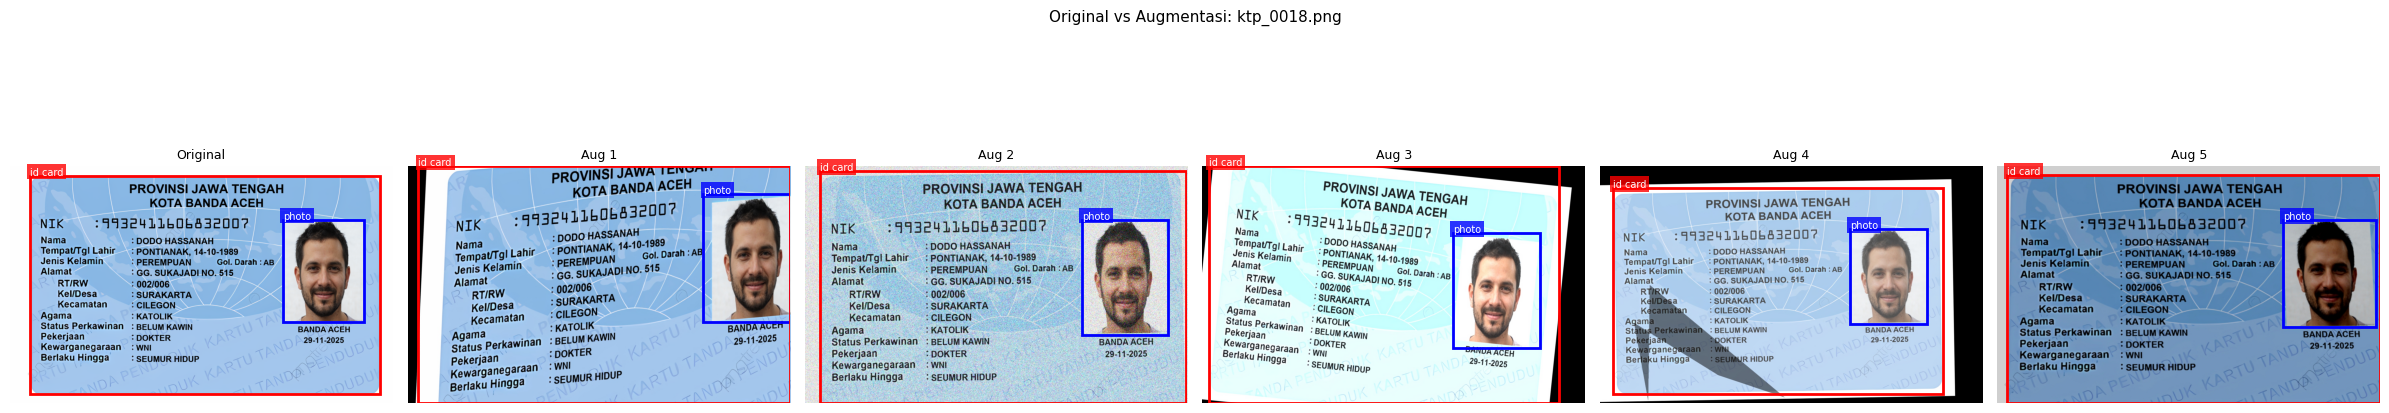

In [16]:
def visualize_augmentation(n_sample=3):
    orig_files = sorted([
        f for f in os.listdir(IMAGE_DATA_DIR)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    samples = random.sample(orig_files, min(n_sample, len(orig_files)))

    for filename in samples:
        stem = Path(filename).stem

        aug_files = sorted([
            f for f in os.listdir(OUTPUT_IMAGE_DIR)
            if f.startswith(stem + "_aug")
        ])

        if not aug_files:
            print(f"Tidak ada hasil augmentasi untuk {filename}, skip.")
            continue

        aug_files = aug_files[:5]
        total_cols = 1 + len(aug_files)

        fig, axes = plt.subplots(1, total_cols, figsize=(4 * total_cols, 5))
        fig.suptitle(f"Original vs Augmentasi: {filename}", fontsize=11, y=1.02)

        orig_img_path   = os.path.join(IMAGE_DATA_DIR, filename)
        orig_label_path = os.path.join(LABEL_GDINO_DIR, stem + ".txt")

        orig_img  = cv2.imread(orig_img_path)
        orig_img  = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        boxes, class_ids = read_label(orig_label_path)

        draw_boxes(axes[0], orig_img, boxes, class_ids)
        axes[0].set_title("Original", fontsize=9)

        for col, aug_file in enumerate(aug_files, start=1):
            aug_stem      = Path(aug_file).stem
            aug_img_path  = os.path.join(OUTPUT_IMAGE_DIR, aug_file)
            aug_label_path = os.path.join(OUTPUT_LABEL_DIR, aug_stem + ".txt")

            aug_img = cv2.imread(aug_img_path)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            aug_boxes, aug_class_ids = read_label(aug_label_path)

            draw_boxes(axes[col], aug_img, aug_boxes, aug_class_ids)
            axes[col].set_title(f"Aug {col}", fontsize=9)

        plt.tight_layout()
        plt.savefig(f"viz_aug_{stem}.png", dpi=120, bbox_inches="tight")
        plt.show()

visualize_augmentation(n_sample=3)

# **Training Model**

In [17]:
DATASET_DIR = "/content/ktp_dataset"

for split in ["train", "val"]:
    os.makedirs(f"{DATASET_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{DATASET_DIR}/labels/{split}", exist_ok=True)

In [18]:
all_images = sorted([f for f in os.listdir(OUTPUT_IMAGE_DIR) if f.endswith((".jpg", ".png"))])
random.seed(42)
random.shuffle(all_images)

In [19]:
split_idx  = int(len(all_images) * 0.8)
train_files = all_images[:split_idx]
val_files   = all_images[split_idx:]

In [20]:
def copy_split(files, split):
    for filename in files:
        stem = Path(filename).stem

        src_img   = os.path.join(OUTPUT_IMAGE_DIR, filename)
        src_label = os.path.join(OUTPUT_LABEL_DIR, stem + ".txt")

        dst_img   = f"{DATASET_DIR}/images/{split}/{filename}"
        dst_label = f"{DATASET_DIR}/labels/{split}/{stem}.txt"

        shutil.copy(src_img, dst_img)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

copy_split(train_files, "train")
copy_split(val_files,   "val")

In [21]:
# data.yaml
yaml_content = f"""
path: {DATASET_DIR}
train: images/train
val:   images/val

nc: 2
names:
  0: id card
  1: photo
"""

with open(f"{DATASET_DIR}/data.yaml", "w") as f:
    f.write(yaml_content.strip())

## **Setup MLflow**


In [22]:
DRIVE_DIR = "/content/drive/MyDrive/yolo-ektp"
MLFLOW_DIR = f"{DRIVE_DIR}/mlruns"
MODEL_DIR = f"{DRIVE_DIR}/models"

os.makedirs(MLFLOW_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

mlflow.set_tracking_uri(f"file://{MLFLOW_DIR}")
mlflow.set_experiment("yolo-ektp-detection")

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///content/drive/MyDrive/yolo-ektp/mlruns/714025859274225792', creation_time=1771563198796, experiment_id='714025859274225792', last_update_time=1771563198796, lifecycle_stage='active', name='yolo-ektp-detection', tags={}>

In [27]:
def train_yolo_with_mlflow(
    model_name="yolov8n.pt",
    epochs=50,
    imgsz=640,
    batch=16,
    run_name=None
):

    mlflow.end_run()

    with mlflow.start_run(run_name=run_name) as run:
        print(f"Run ID: {run.info.run_id}")

        params = {
            "model": model_name,
            "epochs": epochs,
            "imgsz": imgsz,
            "batch": batch,
            "optimizer": "auto",
            "dataset": "ektp-indonesia",
        }
        mlflow.log_params(params)

        # --- Training ---
        model = YOLO(model_name)
        results = model.train(
            data="/content/ktp_dataset/data.yaml",
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            project="/content/runs",
            name="train",
            exist_ok=True,
        )

        # --- Log Metrics ---
        metrics = {
            "mAP50":      results.results_dict.get("metrics/mAP50(B)", 0),
            "mAP50_95":   results.results_dict.get("metrics/mAP50-95(B)", 0),
            "precision":  results.results_dict.get("metrics/precision(B)", 0),
            "recall":     results.results_dict.get("metrics/recall(B)", 0),
            "box_loss":   results.results_dict.get("train/box_loss", 0),
            "cls_loss":   results.results_dict.get("train/cls_loss", 0),
        }
        mlflow.log_metrics(metrics)

        # --- Simpan Model ke Drive & Log sebagai Artifact ---
        run_id_short = run.info.run_id[:8]
        best_weight_src = "/content/runs/train/weights/best.pt"
        best_weight_dst = f"{MODEL_DIR}/best_{run_name}_{run_id_short}.pt"

        shutil.move(best_weight_src, best_weight_dst)
        mlflow.log_artifact(best_weight_dst, artifact_path="weights")

        # Log confusion matrix & grafik jika ada
        results_dir = "/content/runs/train"
        for file in ["confusion_matrix.png", "results.png", "PR_curve.png"]:
            fpath = os.path.join(results_dir, file)
            if os.path.exists(fpath):
                mlflow.log_artifact(fpath, artifact_path="plots")

        return run.info.run_id, metrics

## **YOLO26**

In [28]:
run_id, metrics = train_yolo_with_mlflow(
    model_name="yolo26n.pt",
    epochs=50,
    imgsz=640,
    batch=16,
    run_name="yolo26"
)

Run ID: 5c0b996494d2448da3452b2e20aa1db3
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ktp_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimi

2026/02/20 05:31:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/20 05:31:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2026/02/20 05:31:43 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2026/02/20 05:31:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(5c0b996494d2448da3452b2e20aa1db3) to file:///content/drive/MyDrive/yolo-ektp/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      3.13G     0.4906      3.293   0.009506         85        640: 100% ━━━━━━━━━━━━ 50/50 5.9it/s 8.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 7.8it/s 0.9s
                   all        200        400    0.00668          1      0.733      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      3.13G     0.4775       2.09   0.009292         88        640: 100% ━━━━━━━━━━━━ 50/50 6.3it/s 7.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━

## **YOLOv11**

In [29]:
run_id2, metrics2 = train_yolo_with_mlflow(
    model_name="yolo11n.pt",
    epochs=50,
    imgsz=640,
    batch=8,
    run_name="yolo11"
)

Run ID: 78b4b33602a943e28d911e2f9a9c2cad
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA A100-SXM4-40GB, 40441MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ktp_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimiz

2026/02/20 05:39:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/20 05:39:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2026/02/20 05:39:39 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2026/02/20 05:39:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


MLflow: logging run_id(78b4b33602a943e28d911e2f9a9c2cad) to file:///content/drive/MyDrive/yolo-ektp/mlruns
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/runs/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/50      1.92G        0.5      1.511      1.054         43        640: 100% ━━━━━━━━━━━━ 100/100 4.7it/s 21.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.2it/s 4.1s
                   all        200        400      0.963      0.964      0.993      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      1.92G     0.4342     0.6293     0.9952         40        640: 100% ━━━━━━━━━━━━ 100/100 10.6it/s 9.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━